In [8]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

## reading and cleaning csv

In [12]:
df = pd.read_csv('spamham.csv')
df.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'],axis = 1,inplace = True)
df.rename(columns = {'v1':'spam','v2':'message'},inplace = True)
df['spam'] = df['spam'].map({'ham':False,'spam':True})
df.head()

,spam,message
0,False,"Go until jurong point, crazy.. Available only ..."
1,False,Ok lar... Joking wif u oni...
2,True,Free entry in 2 a wkly comp to win FA Cup fina...
3,False,U dun say so early hor... U c already then say...
4,False,"Nah I don't think he goes to usf, he lives aro..."


## splitting into train and test

In [14]:
split = int(df.shape[0]*0.70)
train_spam = df[:split]
test_spam = df[split+1:]
train_spam.shape
test_spam.shape

(1671, 2)

## counting words fn

In [16]:
def count_words(msg):
    word_count = {}
    for line in msg:
        for word in line.split():
            if word in word_count:
                word_count[word]+=1
            else:
                word_count[word] = 1
    return word_count

## counting words in spam and ham messages separately

In [18]:
spam_messages = set(train_spam[train_spam['spam'] == True]['message'])
ham_messages = set(train_spam[train_spam['spam'] == False]['message'])
spam_words = count_words(spam_messages)
ham_words = count_words(ham_messages)

## word count plot

In [20]:
def bar_chart_words(words, top=10, messages_type="", color="#1f77b4"):
    top_spam = np.array(sorted(words.items(), key=lambda x: -x[1]))[:top]
    top_words = top_spam[ : :-1, 0]
    top_words_count = [int(i) for i in top_spam[ : :-1, 1]]
    # aesthetics
    if messages_type:
        messages_type = messages_type + " "
    plt.title(f"Top {top} most common words in {messages_type}messages")
    plt.xlabel(f"Number of words")
    plt.barh(top_words, top_words_count, color=color)
    plt.show()

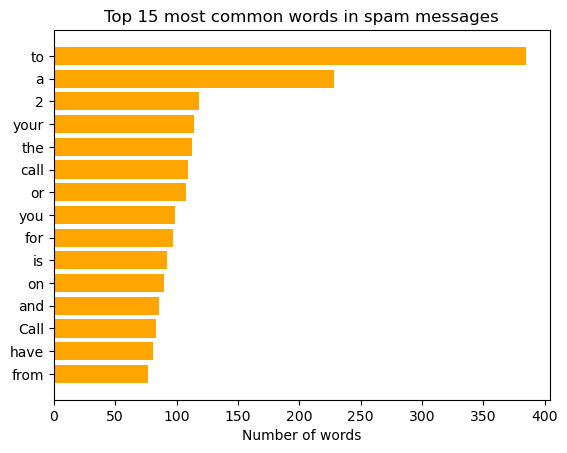

In [22]:
bar_chart_words(spam_words,top=15,messages_type="spam",color="orange")

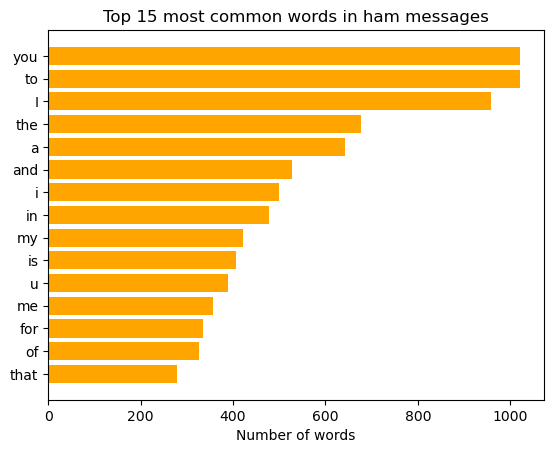

In [24]:
bar_chart_words(ham_words,top=15,messages_type="ham",color="orange")

## pre processing


In [26]:
stop_words = stopwords.words('english')
def pre_process(message):
    line = message.lower()
    words = word_tokenize(line)
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if len(word)>1]
    words = [PorterStemmer().stem(word) for word in words]    
    return words

## count words after processing

In [28]:
def count_processed_data(data):
    word_count = {}
    for msg in data:
        words = pre_process(msg)
        for word in set(words):
            if word not in word_count:
                word_count[word] = 1
            else:
                word_count[word]+=1
    return word_count

In [30]:
spam_words = count_processed_data(spam_messages)
ham_words = count_processed_data(ham_messages)
spam_words

{'messag': 24,
 'brought': 2,
 'ltd.': 1,
 'connect': 2,
 'gmw': 1,
 'e.g.23g': 1,
 'singl': 5,
 'age': 8,
 'gender': 2,
 'follow': 6,
 'wither': 1,
 'sexi': 12,
 'men': 2,
 'g.': 3,
 'wait': 12,
 'e.g.23f': 1,
 'gay': 4,
 'text': 74,
 'landlin': 22,
 'collect': 30,
 '09061743806': 2,
 'tc': 6,
 '150ppm': 22,
 'tenerif': 7,
 'award': 38,
 'dear': 12,
 'box326': 2,
 'call': 198,
 'cw25wx': 4,
 'dave': 2,
 'sae': 12,
 'holiday': 18,
 'cash': 36,
 'notic': 3,
 '5000': 3,
 'final': 12,
 'sms-08718727870': 1,
 '81618-': 1,
 'top': 11,
 '1st': 15,
 'week': 34,
 'rington': 19,
 'week-stop': 1,
 'subpoli': 2,
 'per': 31,
 'ringtone-get': 1,
 '-sub': 1,
 'weekli': 17,
 'free': 102,
 'free-send': 1,
 'word': 18,
 '18': 18,
 'competit': 2,
 'win': 38,
 'www.txttowin.co.uk': 2,
 'entri': 14,
 '80086': 2,
 '�250': 11,
 '�2000': 15,
 'prize': 56,
 '09058094455': 1,
 'mobil': 67,
 'claim': 68,
 'guarante': 31,
 'line': 22,
 'number': 20,
 '3030.': 3,
 'urgent': 42,
 'land': 14,
 '12hr': 11,
 'valid':

In [32]:
spam_messages = [i for i in spam_messages if len(pre_process(i)) >= 1]
ham_messages = [i for i in ham_messages if len(pre_process(i)) >= 1]

all_messages = spam_messages + ham_messages
all_words = count_processed_data(all_messages)

## prob fucn

In [34]:
def predict(msg,s=1,p=0.5,percentage=False):
    n=0
    word_spam_freq = 0
    word_ham_freq = 0
    for word in pre_process(msg):
        if word in spam_words.keys():
            word_spam_freq = (spam_words[word]/all_words[word])
            print(word_spam_freq)
        if word in ham_words.keys():
            word_ham_freq = (ham_words[word]/all_words[word])
            print(word_ham_freq)
        if not (word_spam_freq+word_ham_freq) == 0 and word in all_words.keys():
            spamminess = (word_spam_freq)/(word_spam_freq+word_ham_freq)
            corr = (s*p + all_words[word]*spamminess)/(s+all_words[word])
            n+=np.log(1-corr)-np.log(corr)
    spam_result = 1/(1+np.e**n)
    
    if percentage:
        print(f"spam prob:{spam_result*100:.2f}%")
    elif spam_result>0.5:
        return True
    else:
        return False


In [36]:
predict("Join SoftUni, FREE Programming Basics course! Don't miss out on this offer! Become a code wizard GUARANTEED!")

0.5172413793103449
0.4827586206896552
0.7391304347826086
0.2608695652173913
1.0
1.0
1.0
0.030612244897959183
0.9693877551020408
0.08333333333333333
0.9166666666666666
0.7741935483870968
0.22580645161290322
0.14285714285714285
0.8571428571428571
0.9375
0.0625
1.0


False

In [38]:
predict("Call me now to win a FREE prize!", percentage=True)

0.5706051873198847
0.42939481268011526
0.8636363636363636
0.13636363636363635
0.7391304347826086
0.2608695652173913
1.0
spam prob:98.80%


In [40]:
predict("Call me when you get home", percentage=True)

0.5706051873198847
0.42939481268011526
0.1936619718309859
0.8063380281690141
0.0196078431372549
0.9803921568627451
spam prob:0.79%


In [92]:
prei("Call me now to win a FREE home!", percentage=True)

0.07042253521126761
0.9295774647887324
1.0
1.0
0.056338028169014086
0.9436619718309859
1.0
1.0
1.0


False

In [100]:
def test(spam_test, ham_test, s=1, p=0.5, details=False):
    '''
    spam_test - list of spam messages to be tested
    ham_test - list of ham messages to be tested
    details - displays additional information
    '''
    spam_count = 0
    ham_count = 0
    for message in spam_test:
        if predict(message, s, p):
            spam_count += 1
        else:
            ham_count += 1

    true_positive = spam_count
    false_negative = ham_count

    spam_count = 0
    ham_count = 0
    for message in ham_test:
        if predict(message, s, p):
            spam_count += 1
        else:
            ham_count += 1

    false_positive = spam_count
    true_negative = ham_count

    # How many selected messages are spam?
    spam_precision = true_positive / (true_positive + false_positive)

    # How many spam messages are selected?
    spam_recall = true_positive / (true_positive + false_negative)

    # Harmonic mean between precision and recall.
    spam_fscore = 2 * (spam_precision * spam_recall) / (spam_precision + spam_recall)

    # How many selected messages are ham?
    ham_precision = true_negative / (true_negative + false_negative)

    # How many ham messages are selected?
    ham_recall = true_negative / (true_negative + false_positive)

    # Harmonic mean between precision and recall.
    ham_fscore = 2 * (ham_precision * ham_recall) / (ham_precision + ham_recall)

    # If the data was ballanced.
    # accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

    # For unballanced data.
    ballanced_accuracy = ( spam_recall + ham_recall ) / 2

    if details:
        print("True Positive: ", true_positive)
        print("False Negative:", false_negative)
        print("True Negative: ", true_negative)
        print(f"False  Positive: {false_positive}\n")

        print(f"Spam precision: {spam_precision*100:.2f}%")
        print(f"Spam recall: {spam_recall*100:.2f}%")
        print(f"Spam F-score: {spam_fscore*100:.2f}%\n")

        print(f"Ham precision: {ham_precision*100:.2f}%")
        print(f"Ham recall: {ham_recall*100:.2f}%")
        print(f"Ham F-score: {ham_fscore*100:.2f}%\n")

    print(f"Accuracy: {ballanced_accuracy*100:.2f}%\n")

In [98]:
test_spam_messages = set(test_spam[test_spam['spam'] == True]['message'])
test_spam_messages = [i for i in test_spam_messages if len(pre_process(i)) >= 1]


test_ham_messages = set(test_spam[test_spam['spam'] == False]['message'])
test_ham_messages = [i for i in test_ham_messages if len(pre_process(i)) >= 1]

In [99]:
test(spam_test=test_spam_messages, ham_test=test_ham_messages, details=True)

NameError: name 'spam' is not defined